In [146]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from numpy.linalg import norm, solve
import numpy as np

import pinocchio

In [157]:
data = np.loadtxt("optimal_solution.txt")

target_state = data[0].T
target_position = target_state[1:8]
target_velocity = target_state[8:15]

data_rk = data[1:202].T
time_rk = data_rk[0]
position_rk = data_rk[1:8]
velocity_rk = data_rk[8:15]
acceleration_rk = data_rk[15:22]
torque_rk = data_rk[22:29]

data_mpc = data[202:].T
time_mpc = data_mpc[0]
position_mpc = data_mpc[1:8]
velocity_mpc = data_mpc[8:15]
acceleration_mpc = data_mpc[15:22]
torque_mpc = data_mpc[22:29]


position_limit = np.array([[-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, -0.0175, -2.8973], 
                          [2.8973, 1.7628, 2.8973, -0.0698, 2.8973, 3.7525, 2.8973]])

velocity_limit = np.array([2.1750, 2.1750, 2.1750, 2.1750, 2.6100, 2.6100, 2.6100])

acceleration_limit = np.array([15.0, 7.5, 10.0, 12.5, 15.0, 20.0, 20.0])

torque_limit = np.array([87, 87, 87, 87, 12, 12, 12])

colors = px.colors.qualitative.Plotly
fig = make_subplots(rows=7, cols=4, column_titles=["position", "velocity", "acceleration", "torque"], row_titles=["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5", "Joint 6", "Joint 7"])

for i in range(7):

    # Plot position trajectory, limit and target
    fig.add_trace(
    go.Scatter(x=time_mpc, y=position_mpc[i, :], line_color=colors[2]),
    row=i+1, col=1 )

    fig.add_trace(
    go.Scatter(x=time_rk, y=position_rk[i, :], opacity=0.2, line_color=colors[2]),
    row=i+1, col=1 )

    fig.add_hline(y=target_position[i],
    row=i+1, col=1, line_dash="dash", line_width=0.5)

    fig.add_hline(y=position_limit[0, i],
    row=i+1, col=1, line_dash="dash", line_width=1)

    fig.add_hline(y=position_limit[1, i],
    row=i+1, col=1, line_dash="dash", line_width=1)

    # Plot velocitiy trajectory, limit and target
    fig.add_trace(
    go.Scatter(x=time_mpc, y=velocity_mpc[i, :], line_color=colors[9]),
    row=i+1, col=2 )

    fig.add_trace(
    go.Scatter(x=time_rk, y=velocity_rk[i, :], opacity=0.5, line_color=colors[9]),
    row=i+1, col=2 )

    fig.add_hline(y=target_velocity[i],
    row=i+1, col=2, line_dash="dash", line_width=0.5)

    fig.add_hline(y=velocity_limit[i],
    row=i+1, col=2, line_dash="dash", line_width=1)

    fig.add_hline(y=-velocity_limit[i],
    row=i+1, col=2, line_dash="dash", line_width=1)

    # Plot acceleration trajectory and limit
    fig.add_trace(
    go.Scatter(x=time_mpc, y=acceleration_mpc[i, :], line_color=colors[1]),
    row=i+1, col=3 )

    fig.add_trace(
    go.Scatter(x=time_rk, y=acceleration_rk[i, :], opacity=0.4, line_color=colors[1]),
    row=i+1, col=3 )

    fig.add_hline(y=acceleration_limit[i],
    row=i+1, col=3, line_dash="dash", line_width=1)

    fig.add_hline(y=-acceleration_limit[i],
    row=i+1, col=3, line_dash="dash", line_width=1)

    # Plot torque , limit and target
    fig.add_trace(
    go.Scatter(x=time_mpc, y=torque_mpc[i, :], line_color=colors[0]),
    row=i+1, col=4 )

    fig.add_trace(
    go.Scatter(x=time_rk, y=torque_rk[i, :], opacity=0.4, line_color=colors[0]),
    row=i+1, col=4 )

    fig.add_hline(y=torque_limit[i],
    row=i+1, col=4, line_dash="dash", line_width=1)

    fig.add_hline(y=-torque_limit[i],
    row=i+1, col=4, line_dash="dash", line_width=1)
    
fig.update_layout(height=2000, width=1000, title_text="PolyMPC collocation_fix_jw branch, poly=3, segment=6, 2SQP, 700QP")
fig.update(layout_showlegend=False)
fig.show()

In [120]:
fig.write_image("results_images/fig1.png")

In [ ]:
for i in range(len(time_rk)):
    pos = traj_data[0, i, :].flatten()
    vel = traj_data[1, i, :].flatten()
    acc = traj_data[2, i, :].flatten()

    zeros = np.zeros(2)
    pos = np.concatenate((pos, zeros))
    vel = np.concatenate((vel, zeros))
    acc = np.concatenate((acc, zeros))

    vel_0 = np.zeros(9)
    acc_0 = np.zeros(9)

    tau = p.calculateInverseDynamics(bodyUniqueId=robotId, objPositions=pos.tolist(), objVelocities=vel.tolist(), objAccelerations=acc.tolist())
    tau = np.array(tau)
    torque_data[0, i, :] = tau
    tau_g = p.calculateInverseDynamics(bodyUniqueId=robotId, objPositions=pos.tolist(), objVelocities=vel_0.tolist(), objAccelerations=acc_0.tolist())
    tau_g = np.array(tau_g)
    torque_data[3, i, :] = tau_g
    tau_no_cor = p.calculateInverseDynamics(bodyUniqueId=robotId, objPositions=pos.tolist(), objVelocities=vel_0.tolist(), objAccelerations=acc.tolist())
    tau_no_cor = np.array(tau_no_cor)
    tau_cor = tau - tau_no_cor
    torque_data[2, i, :] = tau_cor
    # acc term
    torque_data[1, i, :] = tau - tau_cor - tau_g

In [152]:
model = pinocchio.buildModelFromUrdf("../robot_utils/panda-model/panda_arm.urdf")
data  = model.createData()

tau_g = np.zeros_like(position_rk)
tau_corr = np.zeros_like(position_rk)
tau_acc = np.zeros_like(position_rk)
for i in range(np.shape(torque_mpc)[1]):
    pinocchio.crba(model, data, position_rk[:, i])
    tau_g[:, i] = pinocchio.rnea(model, data, position_rk[:, i], np.zeros(7), np.zeros(7))
    tau_acc[:, i] = data.M@acceleration_rk[:,i]
    torque_rk[:, i] = pinocchio.rnea(model, data, position_rk[:, i], velocity_rk[:, i], acceleration_rk[:, i])

tau_corr = torque_rk - tau_g - tau_acc



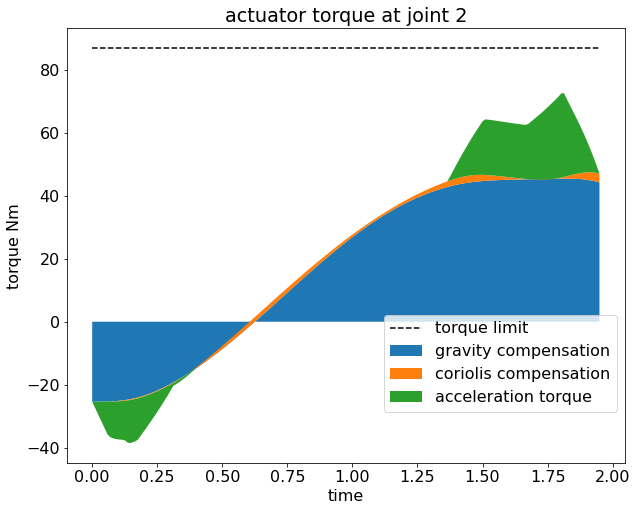

In [155]:
import matplotlib.pyplot as plt

# contribution plot
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(10, 8))
plt.plot(time_rk, 87*np.ones_like(time_rk), "--", color="k")
# plt.stackplot(time_rk, torque_data[1:,:, 1])
plt.stackplot(time_rk, [tau_g[1, :], tau_corr[1, :], tau_acc[1, :]])
plt.xlabel("time")
plt.ylabel("torque Nm")
fig.legend(["torque limit", "gravity compensation", "coriolis compensation", "acceleration torque"], bbox_to_anchor=(0.9, 0.2),
           loc='lower right')
plt.title("actuator torque at joint 2")
# plt.savefig(path_name+"/torque_contribution.png")

plt.show()